In [ ]:
from pathlib import Path
import os, pandas as pd, faiss, numpy as np

# حدّد مجلد مشروعك (المكان اللي فيه photos.csv و artifacts/)
PROJECT_ROOT = Path(r"\\wsl.localhost\Ubuntu\home\othman\code\Othman-02\swipe")

# اختياري: غيّر مجلد العمل الحالي للمشروع
os.chdir(PROJECT_ROOT)

# عرّف المسارات المركزية
ART_DIR  = PROJECT_ROOT / "artifacts"
DATA_DIR = PROJECT_ROOT  # لو photos.csv في نفس جذر المشروع

print("CWD:", Path.cwd())
print("ART_DIR exists:", ART_DIR.exists())


In [1]:
%pip install -U torch torchvision torchaudio \
  "transformers==4.43.3" "sentence-transformers==3.0.1" \
  faiss-cpu accelerate safetensors \
  requests tqdm matplotlib pillow numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

df_photos = pd.read_csv("photos.csv", low_memory=False)
assert {"photo_id","photo_image_url"} <= set(df_photos.columns)
df_photos.head(2)


photo_id                                photo_url  \
0  XMyPniM9LF0  https://unsplash.com/photos/XMyPniM9LF0   
1  rDLBArZUl1c  https://unsplash.com/photos/rDLBArZUl1c   

                                     photo_image_url  \
0  https://images.unsplash.com/uploads/1411949294...   
1  https://images.unsplash.com/photo-141633941111...   

           photo_submitted_at photo_featured  photo_width  photo_height  \
0  2014-09-29 00:08:38.594364              t         4272          2848   
1   2014-11-18 19:36:57.08945              t         3000          4000   

   photo_aspect_ratio          photo_description photographer_username  ...  \
0                1.50   Woman exploring a forest     michellespencer77  ...   
1                0.75  Succulents in a terrarium                ugmonk  ...   

  photo_location_country photo_location_city stats_views stats_downloads  \
0                    NaN                 NaN     2375421            6967   
1                    NaN                 NaN    13784815           82141   

                              ai_description ai_primary_landmark_name  \
0      woman walking in the middle of forest                      NaN   
1  succulent plants in clear glass terrarium                      NaN   

  ai_primary_landmark_latitude ai_primary_landmark_longitude  \
0                          NaN                           NaN   
1                          NaN                           NaN   

  ai_primary_landmark_confidence                     blur_hash  
0                            NaN  L56bVcRRIWMh.gVunlS4SMbsRRxr  
1                            NaN  LvI$4txu%2s:_4t6WUj]xat7RPoe  

[2 rows x 31 columns]

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode
import requests, numpy as np, os
from PIL import Image, ImageFile
from io import BytesIO
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import faiss, torch

ImageFile.LOAD_TRUNCATED_IMAGES = True  # يسمح بفتح صور مقطوعة

# إعدادات
N_SAMPLE    = 1000      # كبداية. لاحقًا: len(df_photos)
MAX_WORKERS = 16        # جرّب 8–16 إذا الشبكة أبطأ
BATCH_URLS  = 128
RESIZE_W    = 512
TIMEOUT     = 12
ART_DIR     = "artifacts"
os.makedirs(ART_DIR, exist_ok=True)

urls_all = df_photos["photo_image_url"].tolist()[:N_SAMPLE]
ids_all  = df_photos["photo_id"].astype(str).tolist()[:N_SAMPLE]

# نموذج CLIP عبر sentence-transformers
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)

# جلسة Requests مع إعادة المحاولة
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
session = requests.Session()
session.headers.update({
    "User-Agent": "clip-fast/1.0",
    "Accept": "image/avif,image/webp,image/*,*/*;q=0.8",
})
adapter = HTTPAdapter(pool_connections=MAX_WORKERS, pool_maxsize=MAX_WORKERS,
                      max_retries=Retry(total=3, backoff_factor=0.25,
                                        status_forcelist=[429,500,502,503,504]))
session.mount("http://", adapter); session.mount("https://", adapter)

def clamp_unsplash(url, w=RESIZE_W, auto=True):
    u = urlparse(url)
    q = parse_qs(u.query)
    q["w"] = [str(w)]
    if auto: q["auto"] = ["format"]
    return urlunparse(u._replace(query=urlencode(q, doseq=True)))

def fetch_img(url):
    try:
        r = session.get(clamp_unsplash(url), timeout=TIMEOUT)
        r.raise_for_status()
        return Image.open(BytesIO(r.content)).convert("RGB")
    except Exception:
        return None

def fetch_batch(urls, ids):
    items = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        fut = {ex.submit(fetch_img, u): i for i,u in enumerate(urls)}
        for f in as_completed(fut):
            i = fut[f]; img = f.result()
            if img is not None:
                items.append((i, img, ids[i]))
    items.sort(key=lambda x: x[0])
    imgs  = [im  for _, im,  _ in items]
    k_ids = [id_ for _,  _, id_ in items]
    return imgs, k_ids


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [10]:
import numpy as np, pandas as pd, faiss

all_embs, kept_ids = [], []
pbar = tqdm(range(0, len(urls_all), BATCH_URLS), desc="Downloading+Encoding", unit="batch")
for s in pbar:
    bu = urls_all[s:s+BATCH_URLS]
    bi = ids_all[s:s+BATCH_URLS]
    imgs, k_ids = fetch_batch(bu, bi)
    pbar.set_postfix_str(f"ok:{len(k_ids)}/{len(bu)}")
    if not imgs:
        continue
    vecs = model.encode(imgs, normalize_embeddings=True,
                    convert_to_tensor=False).astype("float32")
    all_embs.append(vecs); kept_ids.extend(k_ids)

if not all_embs:
    raise RuntimeError("No images were successfully downloaded/encoded. Try lower MAX_WORKERS or higher TIMEOUT.")

image_emb = np.vstack(all_embs)
np.save(f"{ART_DIR}/image_emb_fp16.npy", image_emb.astype("float16"))
pd.DataFrame({"photo_id": kept_ids}).to_csv(f"{ART_DIR}/photo_meta_ids.csv", index=False)

index = faiss.IndexFlatIP(image_emb.shape[1])
index.add(image_emb)
faiss.write_index(index, f"{ART_DIR}/faiss_ip.index")

print("✅ Done:", image_emb.shape)


Downloading+Encoding: 100%|██████████| 8/8 [01:12<00:00,  9.02s/batch, ok:104/104]


✅ Done: (999, 512)


In [3]:
import faiss, pandas as pd, numpy as np

index = faiss.read_index(f"{ART_DIR}/faiss_ip.index")
ids_only = pd.read_csv(f"{ART_DIR}/photo_meta_ids.csv").reset_index(drop=True)
ids_only["faiss_pos"] = range(len(ids_only))

meta = ids_only.merge(
    df_photos[["photo_id","photo_image_url"]].assign(photo_id=df_photos["photo_id"].astype(str)),
    on="photo_id", how="left"
).sort_values("faiss_pos").reset_index(drop=True)

print("Index size:", index.ntotal, "| Meta rows:", len(meta))
assert index.ntotal == len(meta), "Mismatch between FAISS index and meta length!"


NameError: name 'ART_DIR' is not defined

In [12]:
import numpy as np, requests, matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def _fetch(url, timeout=10):
    r = requests.get(url, timeout=timeout); r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

def show_grid(df, title=None, max_cols=5):
    n=len(df); cols=min(n,max_cols); rows=(n+cols-1)//cols
    plt.figure(figsize=(3.2*cols,3.2*rows))
    for i,(_,row) in enumerate(df.iterrows(),1):
        plt.subplot(rows, cols, i)
        plt.imshow(_fetch(row["photo_image_url"])); plt.axis("off")
        plt.title(f"{row.get('score',0):.2f}")
    if title: plt.suptitle(title, y=0.99)
    plt.tight_layout(); plt.show()

def _safe_take(df, idxs):
    idxs = [int(i) for i in idxs if 0 <= int(i) < len(df)]
    return df.iloc[idxs].copy()

def search_by_text(query, k=12):
    # لا تستخدم texts= ، مرّر القائمة مباشرة
    q = model.encode([query], normalize_embeddings=True,
                     convert_to_tensor=False).astype("float32")
    D, I = index.search(q, k)
    out = _safe_take(meta, I[0])
    out["score"] = D[0][:len(out)]
    return out.reset_index(drop=True)

def search_by_image_url(url, k=12):
    img = _fetch(url)
    # لا تستخدم images= ، مرّر القائمة مباشرة
    q = model.encode([img], normalize_embeddings=True,
                     convert_to_tensor=False).astype("float32")
    D, I = index.search(q, k)
    out = _safe_take(meta, I[0])
    out["score"] = D[0][:len(out)]
    return out.reset_index(drop=True)


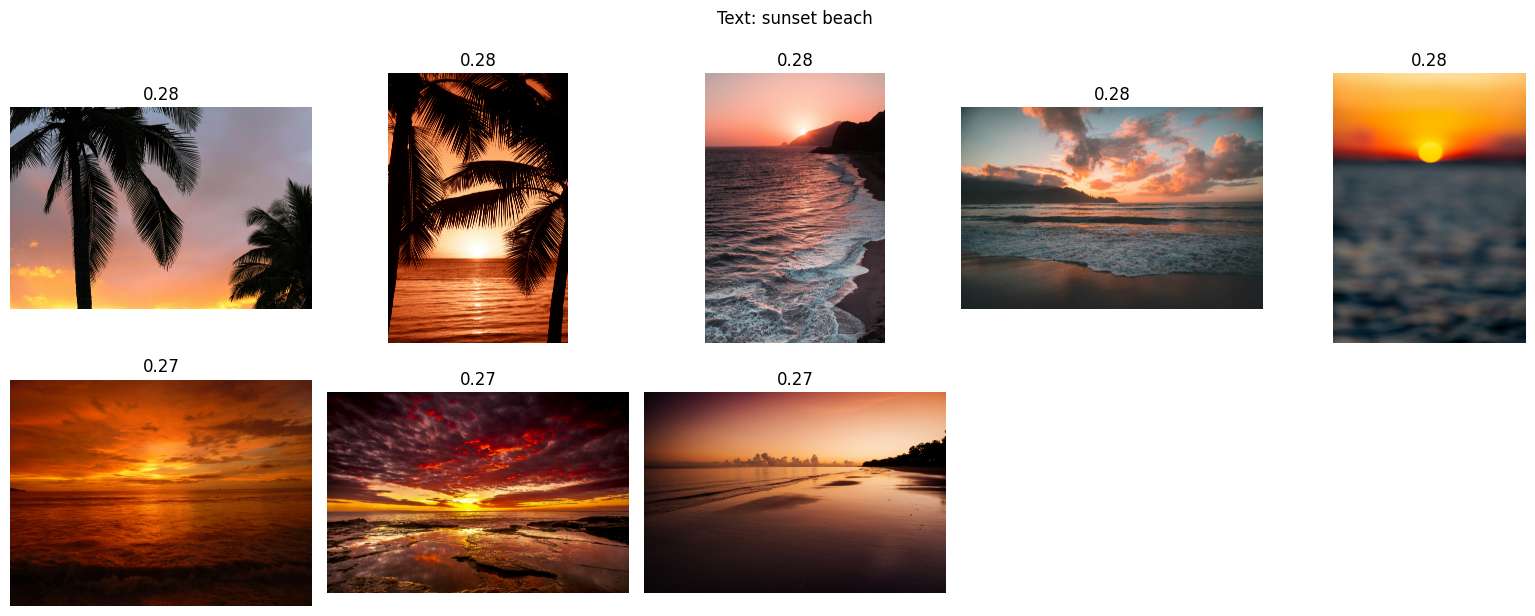

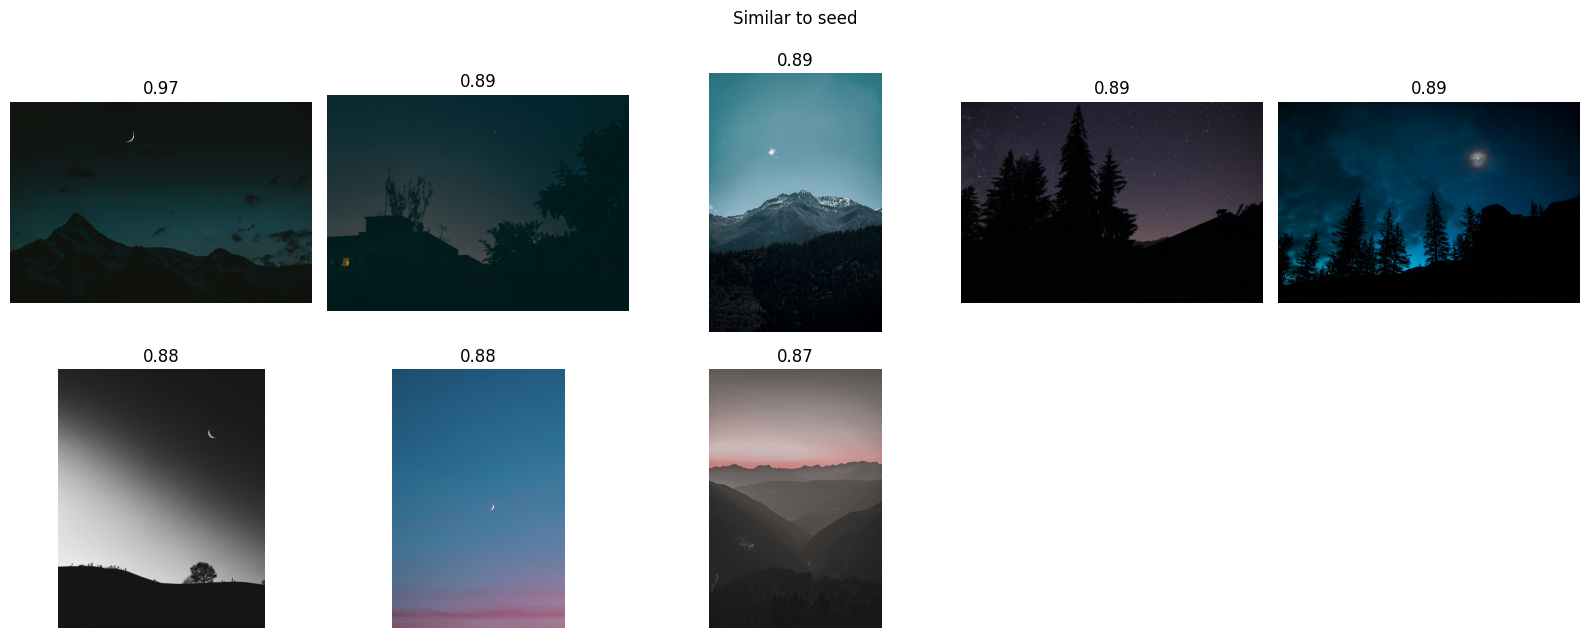

Seed URL: https://images.unsplash.com/photo-1565023998836-962ff9d5f9be


In [13]:
res1 = search_by_text("sunset beach", k=8)
show_grid(res1, "Text: sunset beach")

seed = meta.sample(1, random_state=7).iloc[0]["photo_image_url"]
res2  = search_by_image_url(seed, k=8)
show_grid(res2, "Similar to seed")
print("Seed URL:", seed)


In [14]:
import numpy as np, pandas as pd, faiss

# حمّل المصفوفة والفهرس والميتا
EMB  = np.load("artifacts/image_emb_fp16.npy").astype("float32")  # (N,512)
index = faiss.read_index("artifacts/faiss_ip.index")
meta  = pd.read_csv("artifacts/photo_meta_ids.csv").reset_index(drop=True)
# اربطها بـ df_photos للحصول على الروابط
meta = meta.merge(df_photos[["photo_id","photo_image_url"]].assign(photo_id=df_photos["photo_id"].astype(str)),
                  on="photo_id", how="left")

# خريطة سريعة من photo_id → موضعه في المصفوفة
id2pos = dict(zip(meta["photo_id"], meta.index))

def emb_by_pos(i: int) -> np.ndarray:
    return EMB[i]  # شكلها (512,)

def emb_by_photo_id(pid: str) -> np.ndarray:
    return EMB[id2pos[str(pid)]]

def emb_of_text(text: str) -> np.ndarray:
    v = model.encode([text], normalize_embeddings=True, convert_to_tensor=False).astype("float32")[0]
    return v  # (512,)

def emb_of_image_url(url: str) -> np.ndarray:
    img = _fetch(url)
    v = model.encode([img], normalize_embeddings=True, convert_to_tensor=False).astype("float32")[0]
    return v


In [15]:
# قارن نص مع صورة مثلاً:
v_text = emb_of_text("sunset beach")
v_img  = emb_of_image_url(meta.iloc[0]["photo_image_url"])
cosine = float(np.dot(v_text, v_img))    # بين -1 و 1
cosine


0.1692197322845459

In [ ]:
v_new = emb_of_text("gangule")
scores = EMB @ v_new                    # (N,)
topk   = np.argsort(-scores)[:12]       # أعلى 12
meta.iloc[topk].assign(score=scores[topk])


NameError: name 'emb_of_text' is not defined

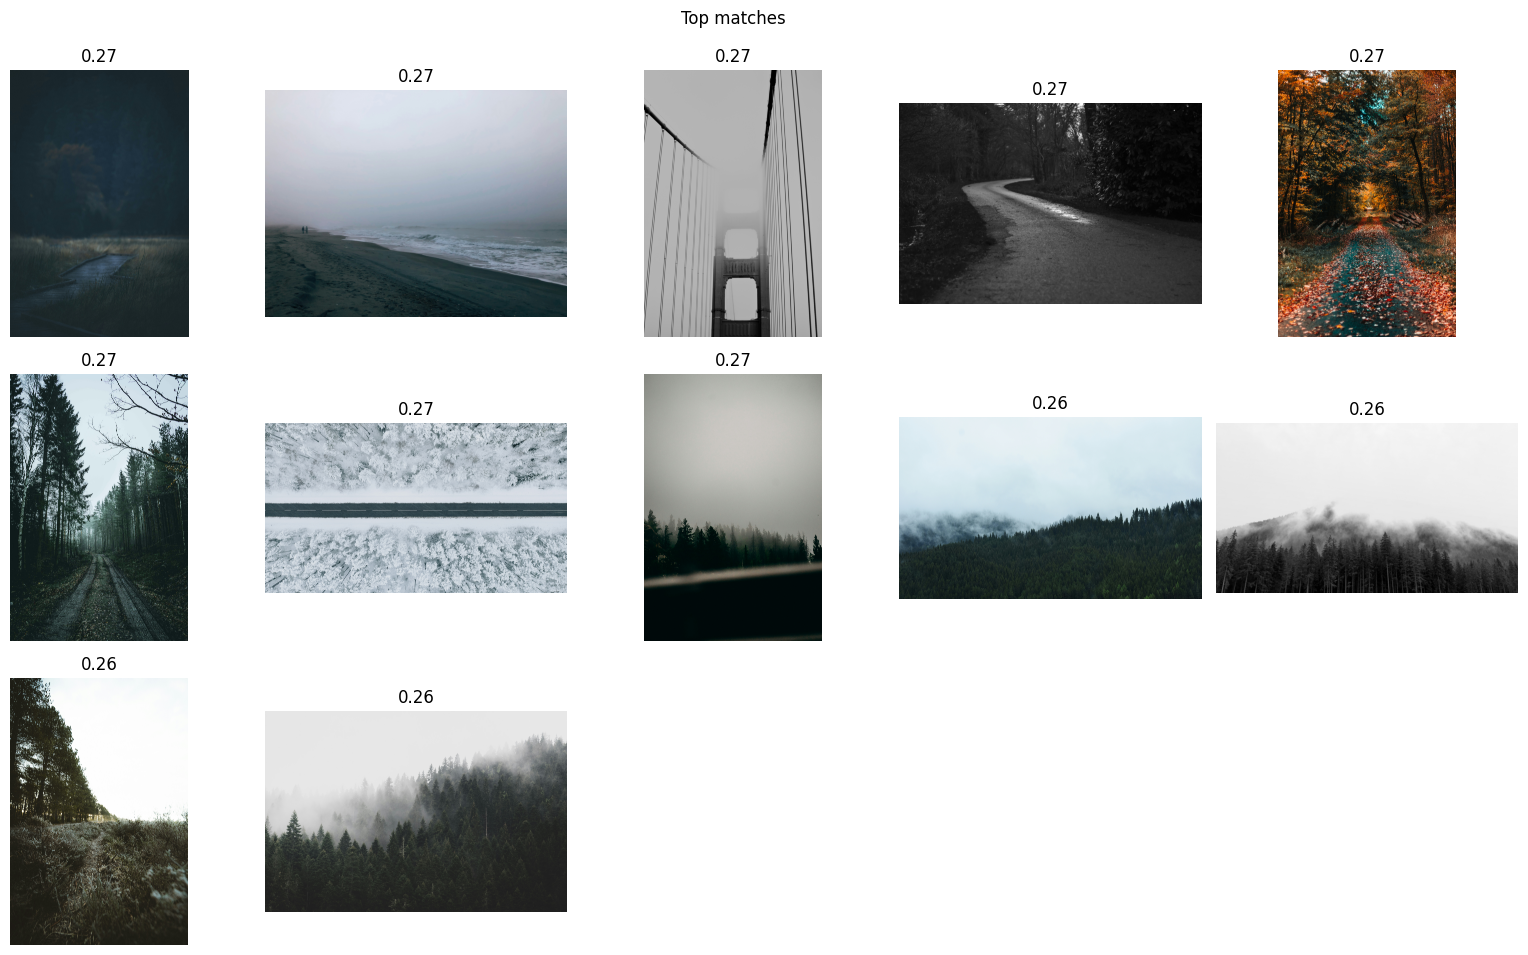

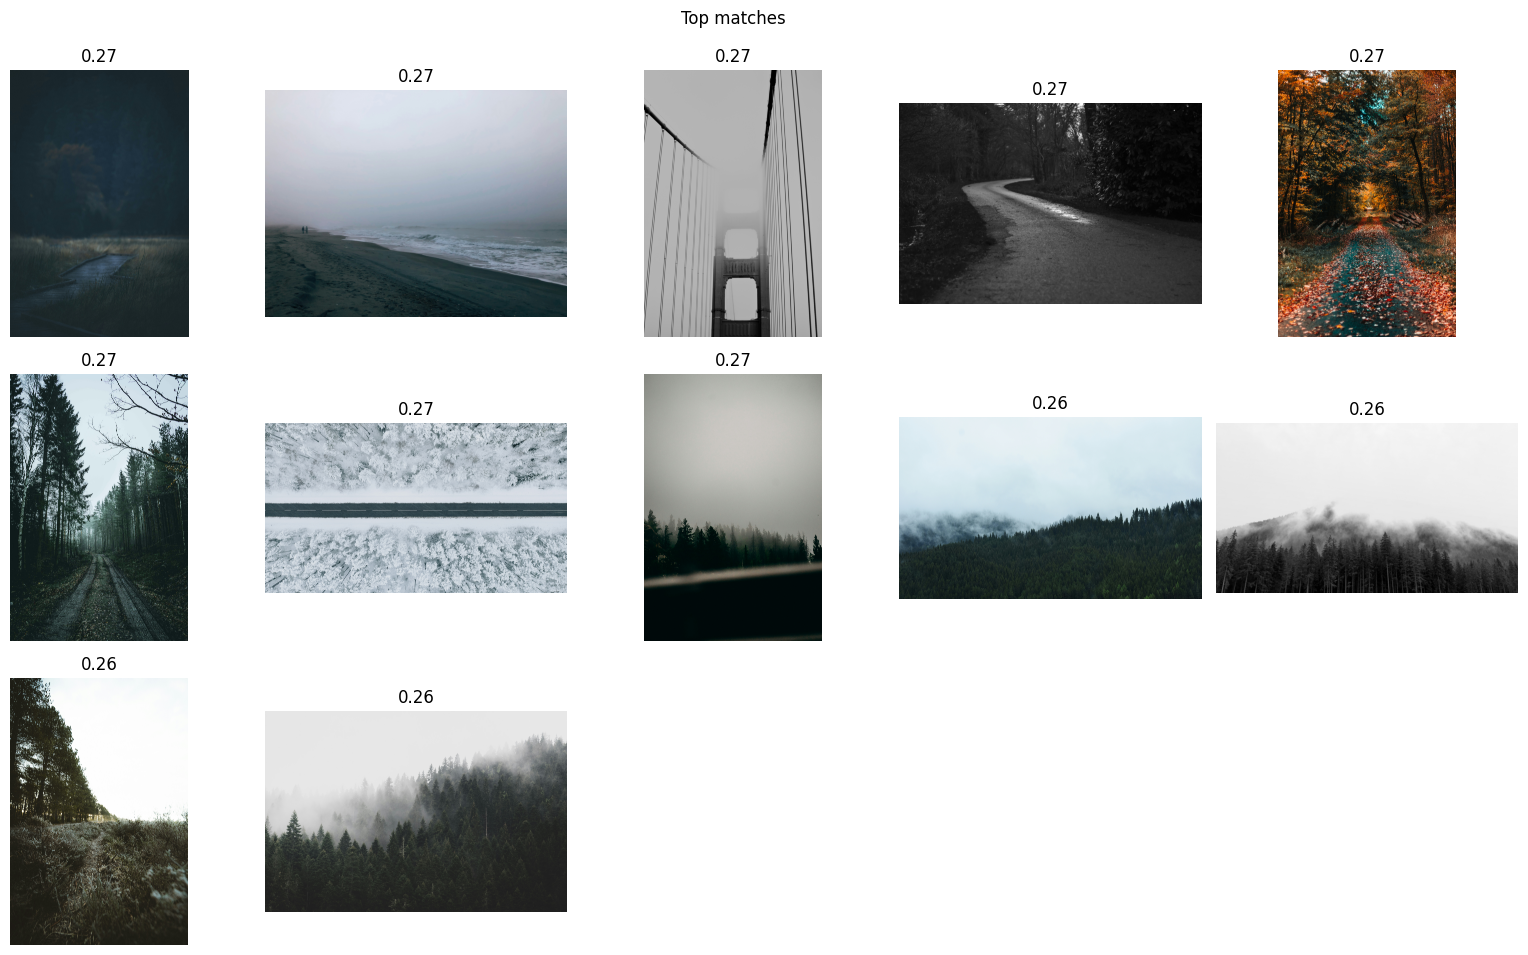

In [25]:
# اصنع DataFrame للنتائج
hits = meta.iloc[topk].assign(score=scores[topk]).reset_index(drop=True)

# إن كان عندك show_grid سابقًا:
show_grid(hits, title="Top matches")

# أو استخدم نسخة خفيفة هنا:
import matplotlib.pyplot as plt, requests
from PIL import Image
from io import BytesIO

def show_grid_from_df(df, title=None, max_cols=5):
    n = len(df); cols = min(n, max_cols); rows = (n+cols-1)//cols
    plt.figure(figsize=(3.2*cols, 3.2*rows))
    for i,(_,row) in enumerate(df.iterrows(), 1):
        img = Image.open(BytesIO(requests.get(row["photo_image_url"], timeout=10).content)).convert("RGB")
        plt.subplot(rows, cols, i); plt.imshow(img); plt.axis("off")
        plt.title(f"{row.get('score',0):.2f}")
    if title: plt.suptitle(title, y=0.99)
    plt.tight_layout(); plt.show()

show_grid_from_df(hits, "Top matches")
